# Probabilité de joindre un client lors du premier appel et lors du deuxième appel en fonction de l'heure et du jour

{0: '0Monday', 1: '1Tuesday', 2: '2Wednesday', 3: '3Thursday', 4: '4Friday'}
{0: 'h10', 1: 'h11', 2: 'h12', 3: 'h14', 4: 'h15', 5: 'h16', 6: 'h17', 7: 'h18', 8: 'h19'}
Les 10 meilleures combinaisons de jours et heures pour le deuxième appel :
    weekday_a2 hour_a2 weekday_a1 hour_a1   prob_no  prob_yes
9     1Tuesday     h10    0Monday     h10  0.660000  0.340000
22  2Wednesday     h15    0Monday     h10  0.674797  0.325203
36     4Friday     h10    0Monday     h10  0.693642  0.306358
31   3Thursday     h15    0Monday     h10  0.732558  0.267442
19  2Wednesday     h11    0Monday     h10  0.736827  0.263173
16    1Tuesday     h18    0Monday     h10  0.745283  0.254717
37     4Friday     h11    0Monday     h10  0.750725  0.249275
32   3Thursday     h16    0Monday     h10  0.751724  0.248276
23  2Wednesday     h16    0Monday     h10  0.758333  0.241667
35   3Thursday     h19    0Monday     h10  0.764228  0.235772


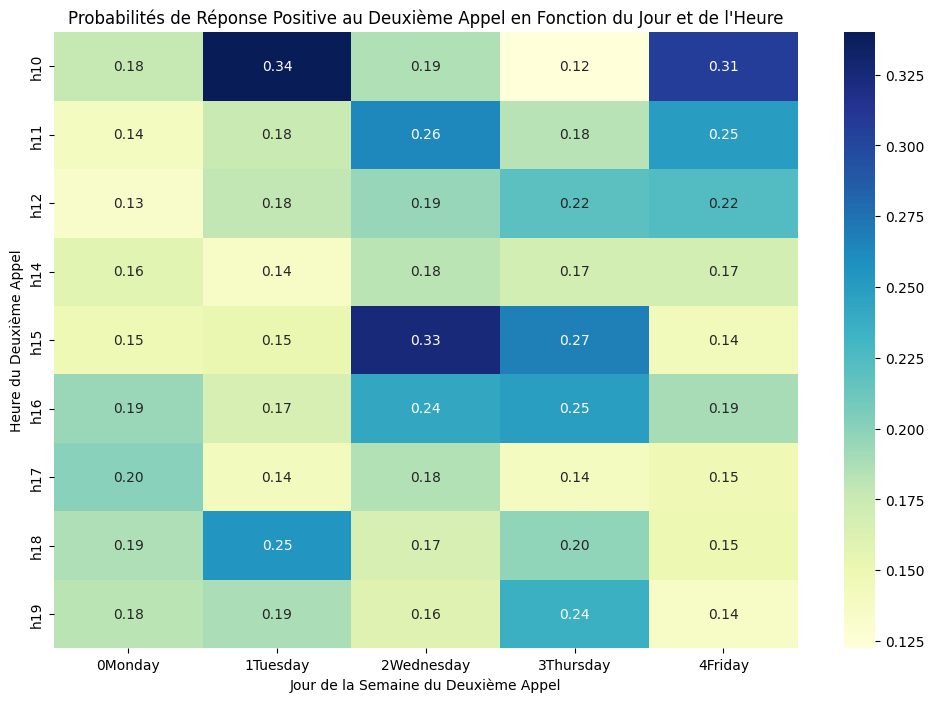

In [12]:
import pandas as pd
import pyAgrum as gum
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
calls_a1 = pd.read_csv("calls_a1.csv/calls_a1.csv")
calls_a2 = pd.read_csv("calls_a2.csv/calls_a2.csv")

# Convertir les colonnes pertinentes en catégories
categorical_columns_a1 = ["weekday_a1", "hour_a1", "lead_answered_a1"]
categorical_columns_a2 = ["weekday_a2", "hour_a2", "lead_answered_a2"]

for col in categorical_columns_a1:
    calls_a1[col] = calls_a1[col].astype('category')

for col in categorical_columns_a2:
    calls_a2[col] = calls_a2[col].astype('category')

# Joindre les deux datasets sur lead_id pour obtenir les informations du premier et du deuxième appel
calls_combined = calls_a1.merge(calls_a2[['lead_id', 'weekday_a2', 'hour_a2', 'lead_answered_a2']], on='lead_id')

# Définir les variables du modèle
var_to_model = ["weekday_a1", "hour_a1", "weekday_a2", "hour_a2", "lead_answered_a2"]

# Créer les variables Labelized pour le modèle bayésien
var_bn = {}
for var in var_to_model:
    nb_values = len(calls_combined[var].cat.categories)
    var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

for var in var_bn:
    for i, label in enumerate(calls_combined[var].cat.categories):
        var_bn[var].changeLabel(i, label)

# Créer le réseau bayésien et ajouter les variables
bn = gum.BayesNet("Deuxième Appel")
for var in var_bn.values():
    bn.add(var)

# Définir la structure du réseau
bn.addArc("weekday_a1", "lead_answered_a2")
bn.addArc("hour_a1", "lead_answered_a2")
bn.addArc("weekday_a2", "lead_answered_a2")
bn.addArc("hour_a2", "lead_answered_a2")

# Apprendre les paramètres du réseau
learner = gum.BNLearner(calls_combined[var_to_model])
learner.fitParameters(bn)

# Fonction de prédiction (déjà fournie)
def predict(bn, data, var_target, show_progress=False):
    inf_bn = gum.LazyPropagation(bn)
    inf_bn.setTargets({var_target})
    nb_data = len(data)
    target_size = bn.variable(var_target).domainSize()
    target_dom = np.array([bn.variable(var_target).label(i) for i in range(target_size)])
    data_records = data.to_dict("records")
    post_prob = np.zeros((nb_data, target_size))
    for i in range(nb_data):
        inf_bn.setEvidence(data_records[i])
        inf_bn.makeInference()
        post_prob[i, :] = inf_bn.posterior(var_target).toarray()
        inf_bn.eraseAllEvidence()
        if show_progress:
            sys.stdout.write("predict progress: {0:3.0%}\r".format(i/nb_data))
    post_prob_df = pd.DataFrame(post_prob, index=data.index, columns=bn.variable(var_target).labels())
    post_prob_df.columns.name = var_target
    return post_prob_df

# Assurer la correspondance exacte des labels
weekday_mapping = {i: label for i, label in enumerate(calls_combined['weekday_a1'].cat.categories)}
hour_mapping = {i: label for i, label in enumerate(calls_combined['hour_a1'].cat.categories)}

# Exemples de valeurs des colonnes
print(weekday_mapping)
print(hour_mapping)

# Générer toutes les combinaisons possibles de jours et d'heures pour le deuxième appel
weekdays_a2 = calls_combined['weekday_a2'].cat.categories
hours_a2 = calls_combined['hour_a2'].cat.categories
combinations = list(itertools.product(weekdays_a2, hours_a2))

# Utiliser les informations du premier appel pour conditionner les prédictions
first_call_info = {"weekday_a1": weekday_mapping[0], "hour_a1": hour_mapping[0]}

# Préparer le DataFrame pour tester les combinaisons
test_data = pd.DataFrame(combinations, columns=['weekday_a2', 'hour_a2'])
for key, value in first_call_info.items():
    test_data[key] = value

# Convertir les colonnes en type 'category'
test_data['weekday_a2'] = test_data['weekday_a2'].astype('category')
test_data['hour_a2'] = test_data['hour_a2'].astype('category')

# Utiliser la fonction predict pour obtenir les probabilités de réponse pour chaque combinaison
pred_prob = predict(bn, data=test_data, var_target='lead_answered_a2', show_progress=False)

# Ajouter les probabilités de réponse à test_data
test_data['prob_no'] = pred_prob['no']
test_data['prob_yes'] = pred_prob['yes']

# Trier les combinaisons par probabilité décroissante de réponse positive
optimal_times = test_data.sort_values(by='prob_yes', ascending=False)
print("Les 10 meilleures combinaisons de jours et heures pour le deuxième appel :")
print(optimal_times.head(10))

# Visualisation des probabilités de réponse positive en fonction du jour de la semaine et de l'heure pour le deuxième appel
plt.figure(figsize=(12, 8))
heatmap_data = test_data.pivot(index="hour_a2", columns="weekday_a2", values="prob_yes")
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Probabilités de Réponse Positive au Deuxième Appel en Fonction du Jour et de l'Heure")
plt.ylabel("Heure du Deuxième Appel")
plt.xlabel("Jour de la Semaine du Deuxième Appel")
plt.show()


### --- --- ---